# Warm up session
1. Load the time series 'MBA_ECG14046_data_22.out' in the ECG dataset
2. Plot the time series
3. Highlight the anomalies in red
4. Calculate and display the average number of anomalies.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

## Load the time series

In [2]:
# Paths & Directories
dataset_path = os.path.join('..', 'data', 'TSB-UAD-Public', 'ECG')
file_name = 'MBA_ECG803_data.out'
file_path = os.path.join(dataset_path, file_name)

In [3]:
# Load the timeseries
df = pd.read_csv(file_path, header=None)
data = df[0].to_numpy()
label = df[1].to_numpy()

## Plot the time series and its anomalies

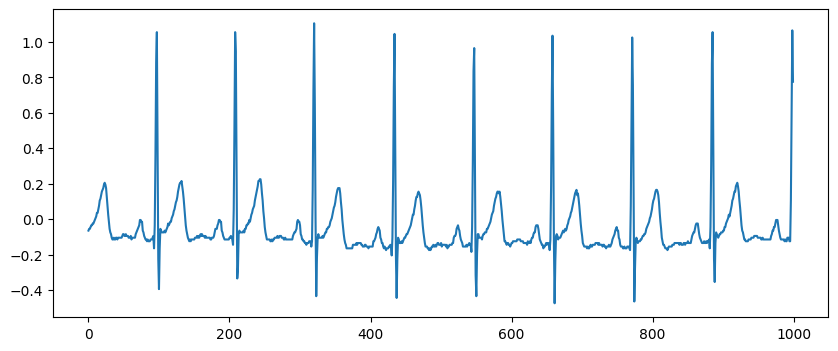

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(data[:1000])
plt.show()

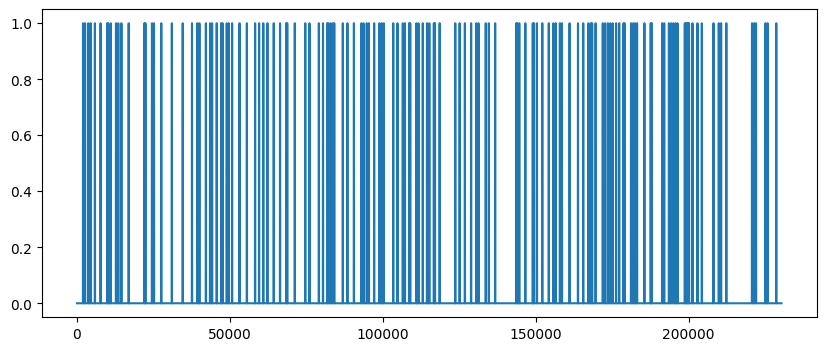

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(label)
plt.show()

## Highlight the anomalies in red

**Question 1:** Write a function that, given a time series and its label, generates a plot of the time series with its anomalies displayed on top of it in red.

**Hint:** Use matplotlib :D

In [10]:
# TODO: Implement the following function
def plot_signal_with_anomalies(x, y, title=None):
    plt.plot(x)
    
    holder = None
    for i in range(len(y)):
        if y[i] == 1 and holder is None:
            holder = i
        elif y[i] == 0 and holder:
            plt.plot(np.arange(holder, i), x[holder:i], color='red')
            holder = None

    if title:
        plt.title(title)

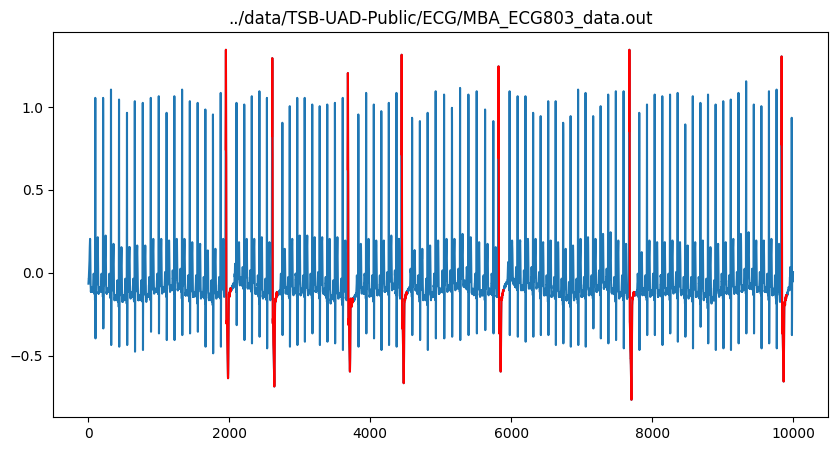

In [11]:
# Test your function here
x = data[:10000]
y = label[:10000]

plt.figure(figsize=(10, 5))
plot_signal_with_anomalies(x, y, title=file_path)
plt.show()

## Find the average number of anomalies for the whole dataset

**Question 2:** Write a function that, given the label of a time series, returns the number of anomalies found in the label.

**Example:** label = 100011111100001110001, expected output = 3 

In [16]:
# TODO: Implement the following function
def compute_number_of_anomalies(y):
    holder = None
    counter = 0

    for i in range(len(y)):
        if y[i] == 1 and holder is None:
            holder = "HAAAAAAAAAAAAA"
            counter += 1
        elif y[i] == 0:
            holder = None

    return counter

compute_number_of_anomalies(label)

147

### Load the whole ECG dataset

In [17]:
# List all files in the dataset directory with '.out' extension
files = [f for f in os.listdir(dataset_path) if f.endswith('.out')]
files_list = []

# Load them
for file_name in files:
    file_path = os.path.join(dataset_path, file_name)
    df = pd.read_csv(file_path, header=None)
    files_list.append({
        "dataset": "ECG",
        "file_name": file_name,
        "data": df[0].to_numpy(),
        "label": df[1].to_numpy(),
    })

### Calculate the average number of anomalies in the ECG dataset

**Question 3:** Calculate the average number of anomalies in the ECG dataset and print the result.

In [18]:
# TODO: Compute the average number of anomalies in all files
n_anomalies = 0

start = time.time()
for file in files_list:
    n_anomalies += compute_number_of_anomalies(file['label'])
end = time.time()

n_anomalies /= len(files)
time_slow = end - start

print(f"Average number of anomalies per file is {n_anomalies:.2f} computed in {time_slow:.2f} secs")

Average number of anomalies per file is 147.00 computed in 0.17 secs


# Detecting anomalies
1. Run 5 anomaly detectors on the same time series, and collect their scores in the list of dictionaries named *scores*
2. Plot the anomaly scores along with the time series and its anomalies in subplots
3. Calculate the accuracy of the anomaly detection using the following metrics:
   - Threshold-based accuracy
   - Area Under the Precision-Recall Curve (AUC-PR)
   - Volume Under the Precision-Recall Curve (VUR-PR)
4. Discuss on what do you think is the most effective anomaly detection method based on the observed results.

## Setup

In [19]:
import math

from sklearn.preprocessing import MinMaxScaler

from tsb_kit.models.feature import Window
from tsb_kit.utils.slidingWindows import find_length

from tsb_kit.models.iforest import IForest
from tsb_kit.models.matrix_profile import MatrixProfile
from tsb_kit.models.pca import PCA
from tsb_kit.models.poly import POLY
from tsb_kit.models.ocsvm import OCSVM
from tsb_kit.models.damp import DAMP
from tsb_kit.models.sand import SAND

# Ignoring warning about deprecated function calls, use 'default' to see warnings
import warnings
warnings.filterwarnings('ignore')

## Run 5 detectors and collect their scores

### Prepare the data for anomaly detection

In [20]:
# Extract the first 10000 points.
x = data[:10000]
y = label[:10000]

# Determine the appropriate length for the sliding window
slidingWindow = find_length(x)

# Convert the data into sliding windows
X_data = Window(window=slidingWindow).convert(x).to_numpy()

print("Estimated Subsequence length: ", slidingWindow)
print("Time series length: ", len(x))
print("Number of abnormal points: ", list(y).count(1))

Estimated Subsequence length:  108
Time series length:  10000
Number of abnormal points:  525


### Compute the scores and save the results in a list of dictionaries

**Question 4:** Use the 5 classifiers, mentioned in the following cells, to compute the anomaly score of x. The first classifier is already implemented. Repeat for the rest

**Hint:** You can visit the repo of *tsb_kit* to check out the implementation of the detectors. Make sure that the produced anomaly scores, and the input time series, have the same length.

In [21]:
scores = []
model_name = 'DAMP'

clf = DAMP(m=slidingWindow, sp_index=slidingWindow + 1)
clf.fit(x)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

In [22]:
model_name='IForest'

# TODO: Repeat the same steps for IForest
clf = IForest()
clf.fit(X_data)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

In [23]:
# Note: This detector is slow only the first time we run it
model_name = 'SAND'

# TODO: Repeat the same steps for SAND
clf = SAND(pattern_length=slidingWindow, subsequence_length= 4 * slidingWindow)
clf.fit(x, online=True, alpha=0.5, init_length=5000, batch_size=2000, verbose=True, overlaping_rate=int(10 * slidingWindow))

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

0-->5000-->7000-->9000-->[STOP]: score length 10000


In [24]:
model_name = 'MatrixProfile'

# TODO: Repeat the same steps for MatrixProfile
clf = MatrixProfile(window = slidingWindow)
clf.fit(x)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

In [25]:
model_name='PCA'

# TODO: Repeat the same steps for PCA
clf = PCA()
clf.fit(X_data)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

## Plot the anomaly scores

**Question 5:** Which method do you think is the best, and which is the worst? Why? You can write your answer in a cell below the plot.

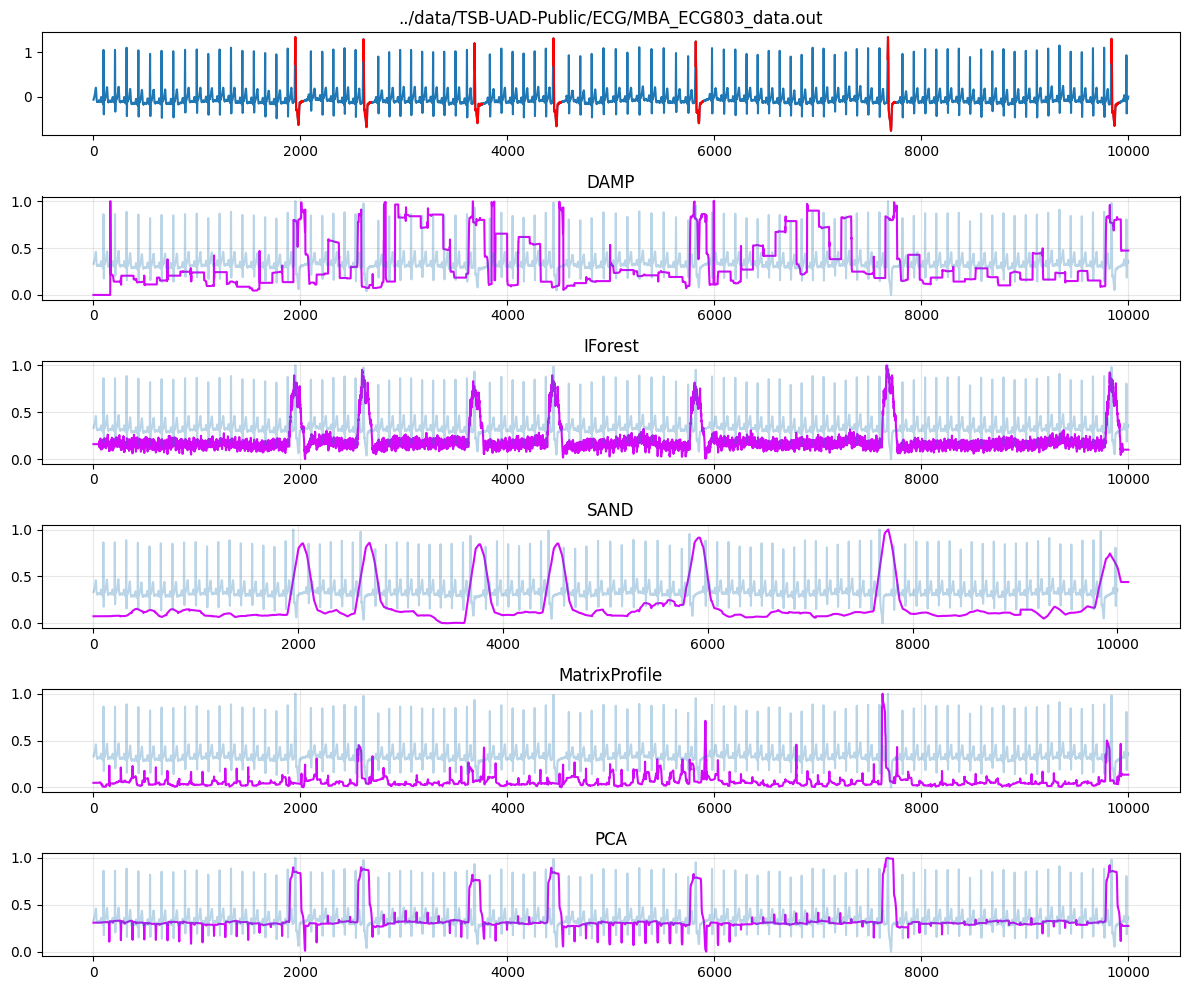

In [26]:
x_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(x.reshape(-1, 1)).ravel()

plt.figure(figsize=(12, 10))
plt.subplot(len(scores) + 1, 1, 1)
plot_signal_with_anomalies(x, y, title=file_path)

for i, elem in enumerate(scores):
    plt.subplot(len(scores) + 1, 1, i + 2)
    plt.title(elem['model_name'])
    plt.plot(elem['score'], color='#D30AFA')
    plt.plot(x_scaled, alpha=0.3)
    plt.grid(alpha=0.3)
    
plt.tight_layout()
plt.show()

## Compute the accuracy

In [28]:
from sklearn.metrics import f1_score, precision_recall_curve, auc
from tsb_kit.vus.metrics import get_metrics

### Find the threshold for each score and save it in the 'scores' list 

In [27]:
for i, elem in enumerate(scores):
    elem['threshold'] = elem['score'].mean() + (3 * elem['score'].std())

### Compute the F1-score for each score and save it

**Question 6:** Use the anomaly threshold determined previously to compute the predicted label of 1s and 0s. Then, use it to compute the F1-score.

In [ ]:
for i, elem in enumerate(scores):
    # elem['predicted_labels'] = ?
    # elem['f1_score'] = ?
for elem in scores: print(f'{elem["model_name"]}: {elem["f1_score"]}')

### Visualize the 5 scores along with their thresholds and F1-scores. What do you notice?

**Question 7:** Why IForest, SAND and PCA have different F1-scores, although they seem to have the same accuracy? Write your answer in a cell below the plot.

In [ ]:
plt.figure(figsize=(12, 10))

for i, elem in enumerate(scores):
    plt.subplot(3, 2, i + 1)
    plt.hlines(y=elem['threshold'], xmin=0, xmax=len(elem['score']), color='red', alpha=0.5)
    plt.fill_between(x=np.arange(0, len(elem['score'])), y1=elem['threshold'], y2=1, color='red', alpha=0.4)
    plt.plot(elem['score'])
    plt.title(f"{elem['model_name']} F1-score: {elem['f1_score']:.2f}")

plt.tight_layout()
plt.show()

### Compute Precision and Recall and save them

**Question 8:** Fill in the code that's missing. Compute precision and recall for multiple different thresholds and save them in the list of dictionaries.

In [ ]:
for elem in scores:
    # elem['precision'], elem['recall'], elem['threshold_list'] = ?
    elem['threshold_list'] = [elem['threshold_list'][0]] + list(elem['threshold_list'])

### Plot Precision, Recall and the Precision-Recall curve

**Question 9:** Which method do you now think is the best, and why? Write your answer in a cell below the plot.

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Precision-Thresholds
plt.subplot(1, 2, 1)
for elem in scores:
    plt.plot(elem['threshold_list'], elem['precision'], label=elem['model_name'])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.legend()

# Plot Recall-Thresholds
plt.subplot(1, 2, 2)
for elem in scores:
    plt.plot(elem['threshold_list'], elem['recall'], label=elem['model_name'])
plt.ylabel('Recall')
plt.xlabel('Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 12))

for i, elem in enumerate(scores):
    plt.subplot(3, 2, i + 1)
    plt.plot(elem['recall'], elem['precision'], label=elem['model_name'], color=f'C{i}')
    plt.fill_between(elem['recall'], 0, elem['precision'], alpha=0.2, color=f'C{i}')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(f"{elem['model_name']} Precision - Recall Curve")
plt.tight_layout()
plt.show()

### Compute AUC-PR

**Question 10:** Fill in the code that's missing. Compute the AUC-PR (Area Under the Precision-Recall Curve) score and save it in *scores*.

In [ ]:
# Compute AUC-PR
for i, elem in enumerate(scores):
    # elem['AUC_PR'] = ?

### Compute AUC-ROC, VUS-PR, VUS-ROC

**Question 11:** Use the *get_metrics* function from the *vus* library to compute the metrics AUC-ROC, VUS-PR, VUS-ROC. Save them in *scores*.

In [ ]:
for elem in scores:
    # results = ?
    for key in ['AUC_ROC', 'VUS_ROC', 'VUS_PR']:
        elem[key] = results[key]

In [ ]:
df_scores = pd.DataFrame(scores)
df_scores[['model_name', 'f1_score', 'AUC_PR', 'AUC_ROC', 'VUS_PR', 'VUS_ROC']]

### Visualize the results

In [ ]:
x = np.arange(0, len(df_scores['model_name']) * 3, 3)
bar_width = 0.5
results_show = ['f1_score', 'AUC_PR', 'AUC_ROC', 'VUS_PR', 'VUS_ROC']
offsets = np.arange(len(results_show)) - (len(results_show) // 2)

fig, ax = plt.subplots(figsize=(8, 8))
for key, offset in zip(results_show, offsets):
    bars = ax.bar(x + (bar_width * offset), df_scores[key], bar_width, label=key)
    ax.bar_label(bars, labels=[f"{x:.2f}" for x in df_scores[key]])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparing all models by scores')
ax.set_xticks(x)
ax.set_xticklabels(df_scores['model_name'])
ax.legend()

plt.grid(color='pink', alpha=0.5)
plt.tight_layout()
plt.show()

### Measure Execution Time

**Question 12:** Rerun the anomaly detectors and compute execution time. Then create the same bar plot as above but for execution time and compare the detectors.

In [ ]:
# TODO: Bar plot for execution time

# Analyse datasets

The following part of this session is **optional**.
1. Load three datasets
2. Run 5 detectors on each
3. Plot the AUC-PR and VUS-PR boxplots
4. What's the best detector now? Is there a best detector? Does this apply to all the time series of the dataset?

In [ ]:
from tqdm import tqdm
from tsb_kit.models.distance import Fourier

tqdm.pandas()

## Load the datasets

In [ ]:
# Add the paths of the datasets we are going to analyse and compare
dataset_path = os.path.join('..', 'data', 'TSB-UAD-Public')
datasets = ['SMD', 'SensorScope', 'MGAB']
dataset_paths = {}

for dataset in datasets:
    dataset_paths.update({
        dataset: os.path.join(dataset_path, dataset)
    })

In [ ]:
# List all files in the dataset directory with '.out' extension
files_list = []
new_files_list = []
timeseries_len = 5000

for dataset in dataset_paths.keys():
    files_list.extend([{
    "dataset": dataset,
    "file_name": f,
} for i, f in enumerate(os.listdir(dataset_paths[dataset])[:20]) if f.endswith('.out') and i%2])

# Load them
for file in files_list:
    file_path = os.path.join(dataset_paths[file['dataset']], file['file_name'])
    df = pd.read_csv(file_path, header=None)
    tmp_data = df[0].to_numpy()
    tmp_label = df[1].to_numpy()

    # Find indices of anomalies
    anomaly_indices = np.where(tmp_label == 1)[0]
    
    if len(anomaly_indices) > 0:
        start_idx = max(0, anomaly_indices[0] - (timeseries_len // 2))
        end_idx = min(len(tmp_data), start_idx + timeseries_len)
        
        # Adjust start index if end index exceeds data length
        start_idx = max(0, end_idx - timeseries_len)
        
        file.update({
            "data": tmp_data[start_idx:end_idx],
            "label": tmp_label[start_idx:end_idx],
        })
        new_files_list.append(file)
    
df = pd.DataFrame(new_files_list)
df

## Run the Anomaly Detectors

### Prepare the data

In [ ]:
df['sliding_window'] = df['data'].apply(find_length)
df['x_sub'] = df.progress_apply(lambda x: Window(window = x['sliding_window']).convert(x['data']).to_numpy(), axis=1)

## Run 5 detectors and collect their scores

**Question 13:** In each one of the function defined below, fill in the missing commands to create and fit the appropriate classifier according to the function's name.

In [ ]:
def norm_score(score, sliding_window):
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    score = np.array([score[0]] * math.ceil((sliding_window - 1) / 2) + list(score) + [score[-1]] * ((sliding_window - 1) // 2))
    return score

def run_SAND(x, sliding_window):
    # TODO: Create and fit the classifier
    
    return MinMaxScaler(feature_range=(0, 1)).fit_transform(clf.decision_scores_.reshape(-1, 1)).ravel()
    
def run_POLY(x, sliding_window):
    # TODO: Create and fit the classifier
    
    measure = Fourier()
    measure.detector = clf
    measure.set_param()
    
    clf.decision_function(measure=measure)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()

    return score

def run_PCA(x_sub, sliding_window):
    # TODO: Create and fit the classifier
    
    return norm_score(clf.decision_scores_, sliding_window)

def run_IForest(x_sub, sliding_window):
    # TODO: Create and fit the classifier
    
    return norm_score(clf.decision_scores_, sliding_window)

def run_OCSVM(X_train, X_test, sliding_window):
    X_train_ = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_train.T).T
    X_test_ = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_test.T).T
    
    # TODO: Create and fit the classifier
    
    return norm_score(clf.decision_scores_, sliding_window)

In [ ]:
# Run the 5 detectors in all time series. This should take about 3 minutes
df['SAND_score'] = df.progress_apply(lambda x: run_SAND(x['data'], x['sliding_window']), axis=1)
df['POLY_score'] = df.progress_apply(lambda x: run_POLY(x['data'], x['sliding_window']), axis=1)
df['PCA_score'] = df.progress_apply(lambda x: run_PCA(x['x_sub'], x['sliding_window']), axis=1)
df['IForest_score'] = df.progress_apply(lambda x: run_IForest(x['x_sub'], x['sliding_window']), axis=1)
df['OCSVM_score'] = df.progress_apply(lambda x: run_OCSVM(x['x_sub'][:int(0.1*len(x['x_sub']))], x['x_sub'], x['sliding_window']), axis=1)

## Compute & Plot the AUC-PR in Boxplots

**Question 14:** Implement the following function to compute and return the Area Under the Precision-Recall Curve (AUC-PR). Given the true labels (y) of a time series and the corresponding detection scores (score), complete the function to perform this calculation

In [ ]:
# TODO: Implement the following function
def compute_auc(y, score):
    pass

**Question 15:** Fill in the commands, and use the function you just implemented, to compute AUC-PR for all time series in the dataframe.

In [ ]:
detectors = [
    'POLY',
    'PCA',
    'IForest',
    'SAND',
    'OCSVM'
]

# TODO: Fill in what's missing to compute AUC-PR for every detectors' score and every time series
for detector in detectors:
    df[f'{detector}_AUC_PR'] = df.progress_apply(lambda x: _________, axis=1)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, dataset in enumerate(datasets):
    tmp_df = df[df['dataset'] == dataset].filter(like='AUC_PR')
    tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
    labels = list(tmp_df.columns)
    
    axes[0, i].boxplot(tmp_df.values)
    axes[0, i].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
    axes[0, i].set_title(dataset)
    
    axes[0, i].set_ylabel('AUC-PR Distribution') if i == 0 else None
    axes[0, i].grid(alpha=0.7, color='pink')

    axes[1, i].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
    axes[1, i].set_ylabel('AUC-PR Mean') if i == 0 else None
    axes[1, i].grid(alpha=0.7, color='pink')

    axes[2, i].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
    axes[2, i].set_ylabel('AUC-PR Median') if i == 0 else None
    axes[2, i].grid(alpha=0.7, color='pink')
    axes[2, i].set_xlabel('Detectors')

plt.tight_layout()
plt.show()

# Bonus question: Can we do better ?
1. Averaging Ensemble
2. Model Selection

## Compute Averaging Ensemble score, its AUC-PR and put it in the box plot.

**Question 16:** Compute the Averaging Ensemble, that is the average of the anomaly scores that we computed before. Save it in the dataframe.

In [ ]:
# Drop 'AVG_ENS_score' column if it exists, in case we run this cell more than once
if 'AVG_ENS_score' in df.columns:
    df = df.drop('AVG_ENS_score', axis=1)

scores_df = df.filter(like='_score')

# TODO: Calculate the averaging ensemble for each time series
# df['AVG_ENS_score'] = ?

In [ ]:
df['AVG_ENS_AUC_PR'] = df.progress_apply(lambda x: compute_auc(x['label'], x['AVG_ENS_score']), axis=1)

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i, dataset in enumerate(datasets):
    tmp_df = df[df['dataset'] == dataset].filter(like='AUC_PR')
    tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
    labels = list(tmp_df.columns)
    
    axes[0, i].boxplot(tmp_df.values)
    axes[0, i].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
    axes[0, i].set_title(dataset)
    
    axes[0, i].set_ylabel('AUC-PR Distribution') if i == 0 else None

    axes[1, i].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
    axes[1, i].set_ylabel('AUC-PR Mean') if i == 0 else None

    axes[2, i].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
    axes[2, i].set_ylabel('AUC-PR Median') if i == 0 else None
    axes[2, i].set_xlabel('Detectors')

    for k in range(3):
        axes[k, i].grid(alpha=0.7, color='pink') 
        axes[k, i].tick_params(axis='x', labelrotation=25)

# Global results
tmp_df = df.filter(like='AUC_PR')
tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
labels = list(tmp_df.columns)

axes[0, 3].boxplot(tmp_df.values)
axes[0, 3].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
axes[0, 3].set_title("Global")
axes[0, 3].set_ylabel('AUC-PR Distribution') if i == 0 else None

axes[1, 3].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
axes[1, 3].set_ylabel('AUC-PR Mean') if i == 0 else None

axes[2, 3].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
axes[2, 3].set_ylabel('AUC-PR Median') if i == 0 else None
axes[2, 3].set_xlabel('Detectors')

for k in range(3):
    axes[k, 3].grid(alpha=0.7, color='pink') 
    axes[k, 3].tick_params(axis='x', labelrotation=25)

plt.tight_layout()
plt.show()

## Model Selection

**Question (homework):** Can we do better than that? Clone the MSAD repository and evaluate a pretrained model (or train it from scratch :) ), on the datasets we saw here.